<a href="https://colab.research.google.com/github/pacomm5/Plantillas/blob/main/TFM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 
# TFM: DETECTANDO LA NECESIDAD DE FINANCIACIÓN

               
## Francisco Martín
## Isabel Andray
## 19/03/2022
 
 

## Importamos las librerias que vamos a necesitar

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy import stats
from sklearn.tree import DecisionTreeRegressor

import datetime
from datetime import datetime
from fbprophet import Prophet

import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

from statsmodels.tsa.stattools import adfuller
from numpy import log

import pmdarima as pm
from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.pipeline import Pipeline



Importing plotly failed. Interactive plots will not work.


In [ ]:
from __future__ import annotations


## Leemos los ficheros con los datos

In [ ]:
 # Fichero de clientes

df=pd.read_csv('data/TFM_clientes.txt',sep='|',encoding='latin-1')
df=df.sort_values(['id_cl','anno','mes'])
df.head()

,id_cl,anno,mes,importe1,importe2,facturacion_ant,capital,gastos_personal,impuesto_sociedades,cod_sector,des_sector,provincia
46055,1953,2017,1,2458.0,2374.0,NaN,NaN,NaN,NaN,43.0,Actividades de construcción especializada,28
46054,1953,2017,2,2458.0,2374.0,NaN,NaN,NaN,NaN,43.0,Actividades de construcción especializada,28
46053,1953,2017,3,2458.0,2233.0,NaN,NaN,NaN,NaN,43.0,Actividades de construcción especializada,28
46052,1953,2017,4,2458.0,2233.0,NaN,NaN,NaN,NaN,43.0,Actividades de construcción especializada,28
46051,1953,2017,5,2458.0,2233.0,NaN,NaN,NaN,NaN,43.0,Actividades de construcción especializada,28


In [ ]:
 # vemos que columnas tenemos

df.columns

Index(['id_cl', 'anno', 'mes', 'importe1', 'importe2', 'facturacion_ant',
       'capital', 'gastos_personal', 'impuesto_sociedades', 'cod_sector',
       'des_sector', 'provincia'],
      dtype='object')

In [ ]:
 # y que tamaño tiene 

df.shape  

(1226304, 12)

In [ ]:
 # vamos a ver cómo se distribuyen las variables que tenemos

df.describe()

,id_cl,anno,mes,importe1,importe2,facturacion_ant,capital,gastos_personal,impuesto_sociedades,cod_sector,provincia
count,1.226304e+06,1.226304e+06,1.226304e+06,1.188091e+06,1.188091e+06,1.051248e+06,1.051248e+06,1.051248e+06,1.051248e+06,1.226232e+06,1.226304e+06
mean,1.009737e+05,2.018000e+03,6.500000e+00,5.591564e+03,2.347615e+03,2.200613e+07,2.099507e+06,-3.014618e+06,-4.298542e+05,4.707900e+01,2.556414e+01
std,4.909769e+04,8.164969e-01,3.452054e+00,9.880983e+04,4.497712e+04,4.942054e+08,9.645230e+07,4.319625e+07,7.135176e+07,2.268979e+01,1.460582e+01
min,1.953000e+03,2.017000e+03,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-4.525817e+08,-6.844186e+09,-2.085802e+10,1.000000e+00,1.000000e+00
25%,6.042475e+04,2.017000e+03,3.750000e+00,1.820000e+02,7.300000e+01,8.240915e+05,0.000000e+00,-1.244138e+06,-4.106425e+04,3.200000e+01,1.100000e+01
50%,1.053590e+05,2.018000e+03,6.500000e+00,5.760000e+02,2.760000e+02,2.497424e+06,0.000000e+00,-4.489250e+05,-7.546000e+03,4.600000e+01,2.800000e+01
75%,1.436625e+05,2.019000e+03,9.250000e+00,1.770500e+03,9.510000e+02,7.695713e+06,7.091900e+04,-1.605838e+05,-2.380000e+02,5.600000e+01,3.700000e+01
max,1.754750e+05,2.019000e+03,1.200000e+01,1.734737e+07,9.864560e+06,7.289835e+10,1.499469e+10,1.221200e+05,7.500000e+08,1.050000e+02,9.400000e+01


In [ ]:
# Buscamos si tenemso Missing:

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
facturacion_ant,175056,0.142751
capital,175056,0.142751
gastos_personal,175056,0.142751
impuesto_sociedades,175056,0.142751
importe1,38213,0.031161
importe2,38213,0.031161
cod_sector,72,0.000059
des_sector,72,0.000059
id_cl,0,0.000000
anno,0,0.000000


In [ ]:
 #convertimos a caracter en algunos campos que vemos necesarios 

df['id_cl']=df['id_cl'].apply(str)
df["anno"] = df["anno"].apply(str)
df["mes"] = df["mes"].apply(str)
df["cod_sector"] = df["cod_sector"].apply(str)
df["provincia"] = df["provincia"].apply(str)

# rellenamos los missing a cero
df = df.fillna(0)

In [ ]:
 # Creamos la columna de fecha desde varias columnas. 

df["Fecha"] = df["anno"] + "/" + df["mes"] 
df.Fecha = pd.to_datetime(df.Fecha, dayfirst = True)

 # convertimos la variable fecha a indice para poder hacer series
    
df_fecha=df.set_index('Fecha')
df_fecha.head()

,id_cl,anno,mes,importe1,importe2,facturacion_ant,capital,gastos_personal,impuesto_sociedades,cod_sector,des_sector,provincia
Fecha,,,,,,,,,,,,
2017-01-01,1953,2017,1,2458.0,2374.0,0.0,0.0,0.0,0.0,43.0,Actividades de construcción especializada,28
2017-02-01,1953,2017,2,2458.0,2374.0,0.0,0.0,0.0,0.0,43.0,Actividades de construcción especializada,28
2017-03-01,1953,2017,3,2458.0,2233.0,0.0,0.0,0.0,0.0,43.0,Actividades de construcción especializada,28
2017-04-01,1953,2017,4,2458.0,2233.0,0.0,0.0,0.0,0.0,43.0,Actividades de construcción especializada,28
2017-05-01,1953,2017,5,2458.0,2233.0,0.0,0.0,0.0,0.0,43.0,Actividades de construcción especializada,28


['Transporte terrestre y por tubería ']


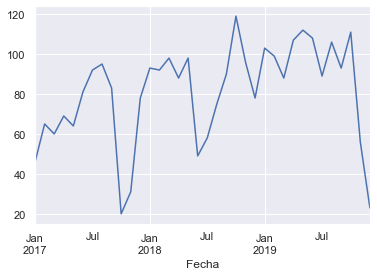

['Venta y reparación de vehículos de motor y motocicletas ']


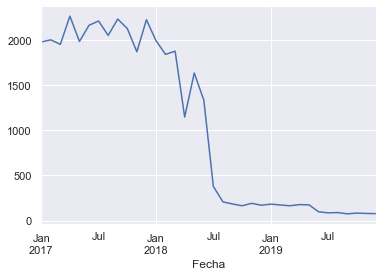

['Servicios de alojamiento ']


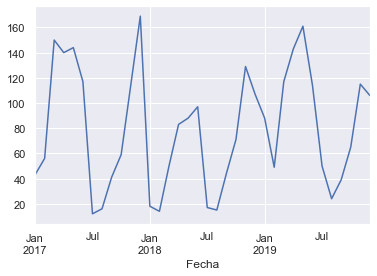

['Silvicultura y explotación forestal ']


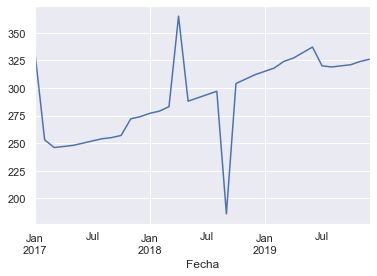

In [ ]:
# creamos un bucle para que nos pinte los primero 20 clientes indvidualmente para ver su comportamiento
for cliente, df_cliente in list(df_fecha.groupby('id_cl'))[:4]:
    print(df_cliente.des_sector.unique())
    df_cliente.resample('M').mean()['importe2'].plot()
    plt.show()

In [ ]:
# vemos que son muy diferentes unos clientes de otros, tanto en comportamiento como en importe 
# vamso a ver si por ramas de actividadnos devuelve más información

0


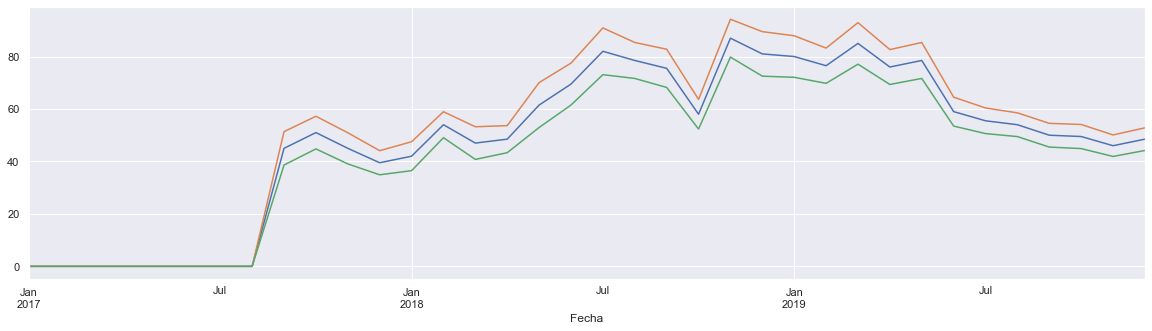

Actividades administrativas de oficina y otras actividades auxiliares a las empresas 


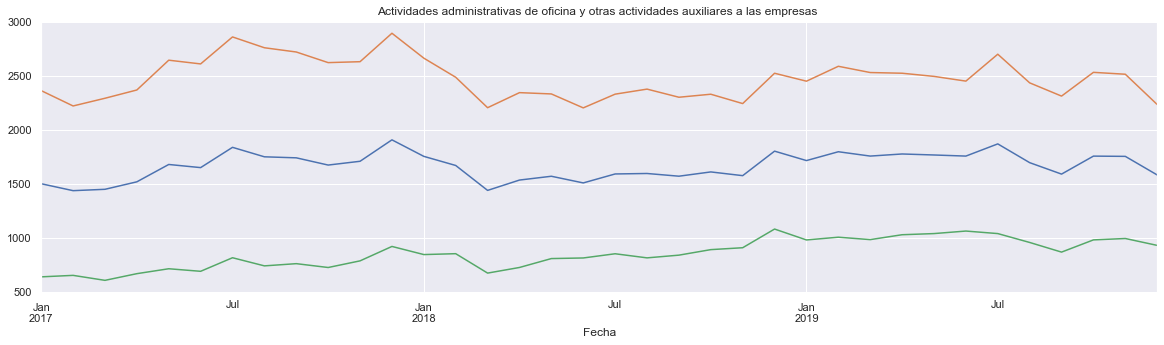

Actividades asociativas 


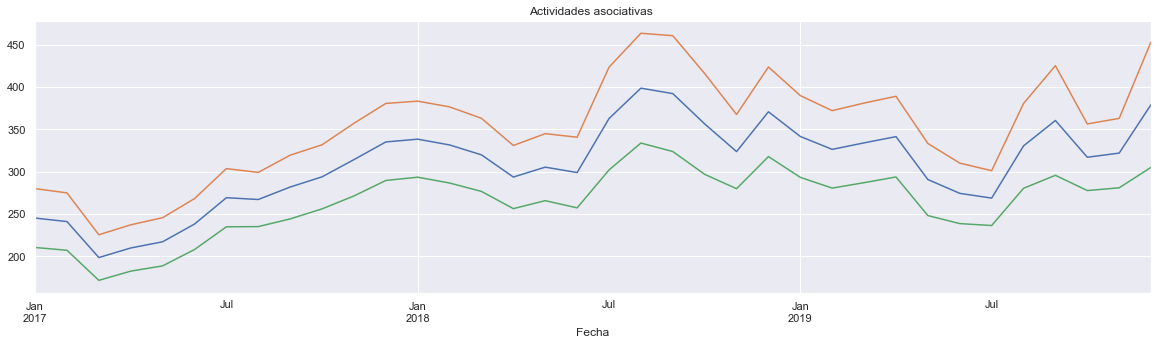

Actividades auxiliares a los servicios financieros y a los seguros 


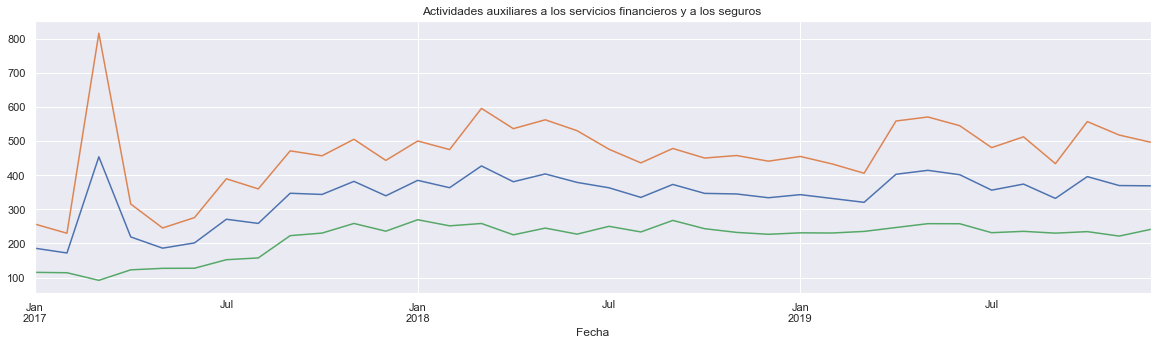

In [ ]:
# creamos un bucle para que nos pinte la media y +- una decima parte de la desviacion a la media para cada sector
for sc, df_sc in list(df_fecha.groupby('des_sector'))[:4]:
    print(sc)
    e = df_sc.resample('M').mean().importe2
    f = df_sc.resample('M').std().importe2
    e.plot(figsize=(20,5), title = sc)
   
    (e+f*0.1).plot(figsize=(20,5), title = sc)
    (e-f*0.1).plot(figsize=(20,5), title = sc)
    
    plt.show()
    

# Vamos a empezar a hacer predicciones a nivel cliente

#  Lo primero que vamos a hacer es buscar la estacionalidad a través de adfuller

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log


In [ ]:
# Creamos una función para que nos calcule el p-valor para detectar estacionalidad

SI_estacional = []
NO_estacional = []

     
for cliente, df_cl_estac in list(df_fecha.groupby('id_cl'))[:100]:
    cutoff = 0.05
    result = adfuller(df_cl_estac.importe2.dropna())

    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    df_cl_estac.pvalue = dfoutput[1]
    if df_cl_estac.pvalue < cutoff:
        SI_estacional.append(cliente)
    else:
        NO_estacional.append(cliente)
    

In [ ]:

len(SI_estacional)

27

In [ ]:

len(NO_estacional)

73

In [ ]:
# el fichero general lo separamos en 2, en funcion de si es estacional o no, para estudiarlos por separado

df_SI_est = df_fecha[df_fecha.id_cl.isin(SI_estacional)]

df_NO_est = df_fecha[df_fecha.id_cl.isin(NO_estacional)]
df_NO_est

,id_cl,anno,mes,importe1,importe2,facturacion_ant,capital,gastos_personal,impuesto_sociedades,cod_sector,des_sector,provincia
Fecha,,,,,,,,,,,,
2017-01-01,100016,2017,1,3796.0,1974.0,2922108.0,0.0,-822884.0,-8351.0,45.0,Venta y reparación de vehículos de motor y mot...,41
2017-02-01,100016,2017,2,3796.0,1998.0,2922108.0,0.0,-822884.0,-8351.0,45.0,Venta y reparación de vehículos de motor y mot...,41
2017-03-01,100016,2017,3,3717.0,1948.0,2922108.0,0.0,-822884.0,-8351.0,45.0,Venta y reparación de vehículos de motor y mot...,41
2017-04-01,100016,2017,4,4024.0,2260.0,2922108.0,0.0,-822884.0,-8351.0,45.0,Venta y reparación de vehículos de motor y mot...,41
2017-05-01,100016,2017,5,3761.0,1980.0,2922108.0,0.0,-822884.0,-8351.0,45.0,Venta y reparación de vehículos de motor y mot...,41
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,100492,2019,8,328.0,116.0,645108.0,0.0,-149505.0,0.0,86.0,Actividades sanitarias,41
2019-09-01,100492,2019,9,255.0,45.0,645108.0,0.0,-149505.0,0.0,86.0,Actividades sanitarias,41
2019-10-01,100492,2019,10,254.0,46.0,645108.0,0.0,-149505.0,0.0,86.0,Actividades sanitarias,41


## Empezamos a predecir ESTACIONALES

In [ ]:
# Nos quedamos con cliente, fecha e importe y llevamos la Fecha a indice
df_fecha_si=df_SI_est.loc[:,['id_cl','importe2']]   
df_fecha_si.head()

,id_cl,importe2
Fecha,,
2017-01-01,100005,46.0
2017-02-01,100005,65.0
2017-03-01,100005,60.0
2017-04-01,100005,69.0
2017-05-01,100005,64.0


In [ ]:


# Cremos las funciones necesarias
    
    # creamos una funcion que nos calcula el valor de hace 2 meses, la diferencia y el incremento
def create_vars(df):
    data = df.copy()
        
    data['imp_2m'] = data['importe2'].shift(2)
    data['dif_imp2']=data['importe2']-data['imp_2m']
    data['incr_imp2']= (data['dif_imp2']/data['imp_2m']).fillna(0)
    
    data['dif_y2m']=data['Y']-data['imp_2m']
    data['incr_y2']= (data['dif_y2m']/data['imp_2m']).fillna(0)
    
    return data

    # calculamos si la tendencia entre 2 meses es positiva o negativa en los datos reales y los predichos
    # nuestro exito sera si lsa 2 tendencias son iguales
def create_tend(df):
    data = df.copy()
    
    data['tend_imp2']= np.where(data['dif_imp2']<=0, -1, 1)
    data['tend_y2m']= np.where(data['dif_y2m']<=0, -1, 1)
    data['exito']=np.where((data['tend_imp2']-data['tend_y2m'])==0,1,0)  
    return data



    ** Ejecutamos una muestra del modelo para poder ver la salida. S No hay capacidad para ejecutarlo todo **

In [ ]:


lista_dfs_cl_tot = []
counter = 1

for cliente, df_cl_pred in list(df_fecha_si.groupby('id_cl'))[:]:
    try:
        print(counter)
        counter += 1
        X=df_cl_pred    

            # creamos un indicador de periodo para trabajar mas comodamente, le pedimos uno mas porque la lista empieza por 0
        i =list(range(37))
        X['periodo']=i[1:]
        
        lista_cli12 = []
            # creamos un rango de 12 meses que son las predicciones que vamos a hacer
        imes=1
        for j in range(0,11):
            print(imes)
            imes+=1
                # Dejamos 2 meses para test
            X_train = X.loc[X.periodo<=24+j]
            y_test = X.loc[(X.periodo>(24+j)) & (X.periodo<=(24+j+2))]

                # creamos el modelo con un autoarima
            model = pm.auto_arima(X_train.importe2, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=4, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=0,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=0, 
                          alpha=0.05,
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
  
            model.fit(X_train.importe2)
                # creamos la prediccion
            n_periods = 2
            fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

                # Make as pandas series
            fitted_series = pd.Series(fitted, index=y_test.index)
            lower_series = pd.Series(confint[:, 0], index=y_test.index)
            upper_series = pd.Series(confint[:, 1], index=y_test.index)
            
            print('fitted',fitted_series)
            
            if lista_cli12:
                lista_cli12.append(fitted[1])
            else:
                lista_cli12.append(fitted[0])
                lista_cli12.append(fitted[1])
            
            
            print('lista pred:', lista_cli12)
            
        # lo llevamos a un dataframe para poderlo unir a nuestro dataframe y comparar 
        # le añadimos el periodo para unir por eses campo
        lista_cli12_b=np.array(lista_cli12)
        data_fit=pd.DataFrame(lista_cli12_b)
        data_fit['periodo']=i[25:]
        print(data_fit)
        
            #cambiamos el nombre a la prediccion
        data_fit=data_fit.rename({0: 'Y'}, axis=1)
            # y unimos a los datos reales. Sólo la prediccion para comparar
        X_fin=pd.merge(X,data_fit,left_on=['periodo'], right_on=['periodo'],how='left').loc[23:]

        print(X_fin)
            
           # Creamos variables nuevas para ver si el resultado es bueno
        Mod_df0=create_vars(X_fin)
            
        print(Mod_df0)
            
        Mod_df=create_tend(Mod_df0).loc[24:] 
            
        print(Mod_df)
        lista_dfs_cl_tot.append(Mod_df)  # solo sacamos la comparativa de las predicciones
                                          # el exito empezara a contar en el periodo 26
    except:
        print(counter, "ha fallado el modelo")
        continue

1
1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=217.857, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=222.210, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=218.151, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=216.133, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=279.909, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=217.694, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=219.693, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.208 seconds
fitted Fecha
2019-01-01    76.570494
2019-02-01    75.099739
dtype: float64
lista pred: [76.57049367138279, 75.09973928739521]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=227.517, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=231.669, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=227.684, Time=0.

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=305.868, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=310.397, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.265 seconds
fitted Fecha
2019-11-01    99.196674
2019-12-01    92.367292
dtype: float64
lista pred: [76.57049367138279, 75.09973928739521, 76.7379963427638, 77.13228905248681, 77.53967155554153, 78.95450951903041, 79.9085865665128, 80.82094905958279, 80.68586231921489, 82.0501094021667, 81.79346154183443, 92.36729193787352]
            0  periodo
0   76.570494       25
1   75.099739       26
2   76.737996       27
3   77.132289       28
4   77.539672       29
5   78.954510       30
6   79.908587       31
7   80.820949       32
8   80.685862       33
9   82.050109       34
10  81.793462       35
11  92.367292       36
     id_cl  importe2  periodo          Y
23  100005      78.0       24        NaN
24  100005     103.0       25  76.570494
25  100005      99.0       26  75.099739
26  100005      

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=295.297, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.207 seconds
fitted Fecha
2019-06-01    303.420611
2019-07-01    292.616657
dtype: float64
lista pred: [275.95833333333337, 275.95833333333337, 277.52, 279.076923076923, 285.6295441622669, 288.81941297140185, 292.6166572915641]
7
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=302.932, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=305.800, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=302.319, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=304.155, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=426.966, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=303.087, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=304.684, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=360.087, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=358.044, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=359.458, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=358.750, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=429.593, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.178 seconds
fitted Fecha
2019-02-01    1219.04
2019-03-01    1219.04
dtype: float64
lista pred: [1230.3750000000005, 1230.3750000000005, 1219.04]
3
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=373.230, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=372.065, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=372.994, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=372.162, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=446.265, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.153 seconds
fitted Fecha
2019

fitted Fecha
2019-11-01    664.915543
2019-12-01    723.631111
dtype: float64
lista pred: [1230.3750000000005, 1230.3750000000005, 1219.04, 1208.5769230769226, 1181.3516690896022, 1174.2069355417884, 1167.7752565743012, 828.5253587043148, 722.8987950600546, 772.3678715468486, 753.500860246432, 723.6311110704336]
              0  periodo
0   1230.375000       25
1   1230.375000       26
2   1219.040000       27
3   1208.576923       28
4   1181.351669       29
5   1174.206936       30
6   1167.775257       31
7    828.525359       32
8    722.898795       33
9    772.367872       34
10   753.500860       35
11   723.631111       36
     id_cl  importe2  periodo            Y
23  100038    1205.0       24          NaN
24  100038     947.0       25  1230.375000
25  100038     947.0       26  1230.375000
26  100038     997.0       27  1219.040000
27  100038     997.0       28  1208.576923
28  100038     997.0       29  1181.351669
29  100038     575.0       30  1174.206936
30  100038     57

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=333.638, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=339.000, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.194 seconds
fitted Fecha
2019-06-01    344.192958
2019-07-01    315.143086
dtype: float64
lista pred: [275.156442259174, 282.2288592139394, 264.5918927264239, 289.26225546095736, 291.1428245436967, 287.4560529273698, 315.14308591083534]
7
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=343.121, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=346.537, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=341.091, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=341.804, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=430.493, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=343.136, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=345.041, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=349.516, Time=0.01 sec

Be

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=120.623, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=125.299, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=126.409, Time=0.04 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 1.044 seconds
fitted Fecha
2019-01-01    56.616268
2019-02-01    56.932173
dtype: float64
lista pred: [56.61626751849393, 56.93217303080002]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=126.815, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=131.045, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129.074, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=130.342, Time=

fitted Fecha
2019-08-01    53.661918
2019-09-01    53.959083
dtype: float64
lista pred: [56.61626751849393, 56.93217303080002, 56.78650268179201, 55.721395594463345, 54.808776276738946, 55.9369163596001, 57.52448271193901, 53.80019319493213, 53.95908338262145]
9
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=157.235, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=161.603, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=159.596, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=160.604, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=349.944, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=158.039, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=154.346, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=161.417, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=158.626, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=156.688, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.246 seconds
fitted Fecha
2019-01-01    27.667785
2019-02-01    26.602287
dtype: float64
lista pred: [27.667785036522478, 26.60228734113705]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=162.414, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=174.998, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=160.973, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=164.277, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=235.323, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=162.304, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=163.976, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=161.934, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.222 seconds
fitted Fecha
2019-02-01

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=208.359, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=210.238, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=208.062, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.257 seconds
fitted Fecha
2019-11-01    26.414115
2019-12-01    25.920343
dtype: float64
lista pred: [27.667785036522478, 26.60228734113705, 26.7198408637844, 27.563868609609628, 27.686887356018378, 27.797776025867833, 26.382128234876973, 27.18325979272819, 28.011967874750194, 28.092800589049254, 28.167116217327063, 25.920342566935712]
            0  periodo
0   27.667785       25
1   26.602287       26
2   26.719841       27
3   27.563869       28
4   27.686887       29
5   27.797776       30
6   26.382128       31
7   27.183260       32
8   28.011968       33
9   28.092801       34
10  28.167116       35
11  25.920343       36
     id_cl  importe2  periodo          Y
23  100097      29.0       24        NaN
24  100097      29.0  

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=244.882, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=246.764, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=250.395, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.227 seconds
fitted Fecha
2019-06-01    79.683686
2019-07-01    73.829539
dtype: float64
lista pred: [49.957890293944, 52.79192174345635, 74.3477602444285, 63.030271929245224, 67.79705188777668, 68.14593523280432, 73.8295389110863]
7
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=253.292, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=259.325, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=252.532, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=255.440, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=340.625, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=253.353, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=255.226, Time=0.07 sec
 ARIMA(1,

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=375.226, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=272.496, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=275.810, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=274.541, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=276.412, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.532 seconds
fitted Fecha
2019-01-01    540.449617
2019-02-01    545.693018
dtype: float64
lista pred: [540.4496166290135, 545.6930176780453]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=285.123, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=295.823, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=284.258, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=291.200, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=390.511, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : 

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=386.164, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=369.537, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=378.708, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=513.133, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=368.746, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=372.165, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=371.100, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.584 seconds
fitted Fecha
2019-10-01    536.789839
2019-11-01    554.392335
dtype: float64
lista pred: [540.4496166290135, 545.6930176780453, 520.9627683145703, 513.6592834900557, 543.2546108325295, 552.0272839111235, 553.1881040982975, 490.1273770104739, 500.3453979866815, 488.60001270955456, 554.392334871945]
11
Performing stepwise search to minimize aic


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=263.628, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=410.298, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.095 seconds
fitted Fecha
2019-06-01    275.310345
2019-07-01    275.310345
dtype: float64
lista pred: [273.7500000000001, 273.7500000000001, 274.12, 274.4999999999999, 274.8518518518519, 275.21428571428567, 275.3103448275861]
7
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=273.997, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=270.247, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=272.166, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=272.140, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=424.496, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.087 seconds
fitted Fecha
2019-07-01    275.866667
2019-08-01    275.866667
dtype: float64
lista pred: [273.7500000000001, 273.7500000000001, 274

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=217.648, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=219.673, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.273 seconds
fitted Fecha
2019-01-01    39.968878
2019-02-01    52.584789
dtype: float64
lista pred: [39.96887762834007, 52.58478944227392]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=225.649, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=225.033, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=223.994, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=274.045, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=225.671, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=227.697, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
T

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=303.958, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=305.364, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=303.001, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=301.962, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=368.226, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=303.957, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=305.962, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=343.061, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.185 seconds
fitted Fecha
2019-11-01    40.298174
2019-12-01    48.574840
dtype: float64
lista pred: [39.96887762834007, 52.58478944227392, 51.850755102403, 50.76775538293002, 50.841117542294214, 49.89154802261152, 49.636082697389966, 48.73589510664185, 50.09798435990922, 50.35279177978622, 49.429118833786745, 48.57483993888954]
            0  periodo
0   39.968878       25
1   52.584789       26
2   51.850755   

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=241.396, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=243.827, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.216 seconds
fitted Fecha
2019-05-01    66.433834
2019-06-01    56.150478
dtype: float64
lista pred: [45.12942535219376, 43.77583404830248, 43.94532482490946, 44.10187937447028, 44.24647888914518, 56.15047752219808]
6
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=250.543, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=249.840, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=248.543, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=248.727, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=308.348, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=250.543, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=252.540, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=258.613, Time=0.00 sec

Best model:  ARIMA(1,0,0

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=209.138, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.247 seconds
fitted Fecha
2019-01-01    17.894474
2019-02-01    17.174924
dtype: float64
lista pred: [17.894473835128966, 17.17492437616517]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=166.782, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=167.087, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=166.332, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=218.111, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 se

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=244.147, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=249.244, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=243.271, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=246.088, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=310.255, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=244.007, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=245.975, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=251.246, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.148 seconds
fitted Fecha
2019-11-01    31.716889
2019-12-01    26.584299
dtype: float64
lista pred: [17.894473835128966, 17.17492437616517, 17.35809909060982, 18.274845217435164, 18.390583469197068, 22.496297385584306, 26.443766584207182, 25.23439269895955, 19.09479473141765, 22.862307906508285, 20.193525092490088, 26.58429942590039]
            0  periodo
0   17.894474

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=229.339, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.214 seconds
fitted Fecha
2019-05-01    40.875001
2019-06-01    42.795311
dtype: float64
lista pred: [45.04896448748261, 45.83606281659688, 59.02710330316444, 42.45200260564016, 34.9560840267376, 42.795311173608596]
6
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=232.638, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=246.755, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=231.180, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=309.634, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=232.911, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=236.273, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] 

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=271.560, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=199.098, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=198.771, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=197.809, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=199.798, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=199.805, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=200.214, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.682 seconds
fitted Fecha
2019-01-01    80.031919
2019-02-01    77.657265
dtype: float64
lista pred: [80.03191927588685, 77.65726515211956]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=210.470, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=214.297, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=213.125, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AI

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=263.002, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=262.552, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=263.586, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 0.601 seconds
fitted Fecha
2019-09-01    68.919043
2019-10-01    65.373965
dtype: float64
lista pred: [80.03191927588685, 77.65726515211956, 83.31115733379988, 54.188529464533254, 58.870220836447615, 64.28096774361879, 65.31253431221444, 77.07519390276738, 69.0614986200437, 65.37396524471818]
10
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=272.689, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=277.298, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=274.680, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=277.220, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=232.760, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.218 seconds
fitted Fecha
2019-03-01    136.681355
2019-04-01    132.884104
dtype: float64
lista pred: [138.8336584183111, 134.33426021830707, 133.23242299804588, 132.8841039516905]
4
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=242.691, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=273.866, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=240.758, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=258.028, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=334.409, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=242.650, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=244.393, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=242.504, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.254 seconds
fitted Fecha
2019-04-01    110.477062
2019-05-0

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=246.360, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=189.260, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=189.102, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.331 seconds
fitted Fecha
2019-01-01    28.298856
2019-02-01    30.410282
dtype: float64
lista pred: [28.298856133636583, 30.410282444542887]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=196.117, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=200.666, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=194.180, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=197.569, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=255.845, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=196.107, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=196.094, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : 

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=257.106, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.251 seconds
fitted Fecha
2019-11-01    47.354031
2019-12-01    44.003948
dtype: float64
lista pred: [28.298856133636583, 30.410282444542887, 28.123666156867976, 28.743576395642428, 25.866304729628304, 31.49652226891537, 33.51454221228492, 35.041530579602245, 38.12606332924896, 38.84288017400385, 40.6993163277165, 44.00394784391444]
            0  periodo
0   28.298856       25
1   30.410282       26
2   28.123666       27
3   28.743576       28
4   25.866305       29
5   31.496522       30
6   33.514542       31
7   35.041531       32
8   38.126063       33
9   38.842880       34
10  40.699316       35
11  44.003948       36
     id_cl  importe2  periodo          Y
23  100252      25.0       24        NaN
24  100252      22.0       25  28.298856
25  100252      24.0       26  30.410282
26  100252  

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=358.125, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=359.801, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=356.148, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=356.267, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=392.580, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=358.142, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=360.142, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=362.736, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.224 seconds
fitted Fecha
2019-05-01    290.245671
2019-06-01    251.354603
dtype: float64
lista pred: [261.8681133631396, 210.60983754350818, 256.45936559728835, 244.7243873982509, 204.6691189827339, 251.3546025272318]
6
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=369.764, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=373.170, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=266.955, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=270.994, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.242 seconds
fitted Fecha
2019-01-01    141.616346
2019-02-01    127.676250
dtype: float64
lista pred: [141.61634577836895, 127.67624991087081]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=279.295, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=278.995, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=277.517, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=277.528, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=320.033, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=279.087, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=278.470, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=282.904, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.266 seconds
fitted Fecha
2019-02

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=398.610, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=402.760, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.233 seconds
fitted Fecha
2019-11-01     91.105017
2019-12-01    120.474608
dtype: float64
lista pred: [141.61634577836895, 127.67624991087081, 148.65551365722092, 194.52849970936302, 128.6985235805616, 128.8488456542743, 127.87157736843136, 129.70970007965244, 136.080063411176, 139.2234280982541, 197.16018100003646, 120.47460819825842]
             0  periodo
0   141.616346       25
1   127.676250       26
2   148.655514       27
3   194.528500       28
4   128.698524       29
5   128.848846       30
6   127.871577       31
7   129.709700       32
8   136.080063       33
9   139.223428       34
10  197.160181       35
11  120.474608       36
     id_cl  importe2  periodo           Y
23  100268     185.0       24         NaN
24  100268     250.0       25  141.616346
25  100268     303.0       26

fitted Fecha
2019-06-01    387.365589
2019-07-01    414.064362
dtype: float64
lista pred: [418.0000000000001, 418.0000000000001, 420.1600000000001, 422.23076923076906, 424.2222222222223, 419.07142857142856, 414.06436164803995]
7
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=368.893, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=368.634, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=367.394, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=367.749, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=449.532, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=369.531, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=377.472, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.303 seconds
fitted Fecha
2019-07-01    323.604366
2019-08-01    374.351434
dtype: float64
lista pred: [418.0000000000001, 418.0000000000001, 420.16

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=299.879, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.201 seconds
fitted Fecha
2019-01-01    1700.054559
2019-02-01    1696.423183
dtype: float64
lista pred: [1700.0545590086351, 1696.4231827990402]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=309.553, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=310.145, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=308.615, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=309.779, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=444.812, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=309.203, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=311.000, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.139 seconds
fitted Fecha
2019-02-01   

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.216 seconds
fitted Fecha
2019-11-01    1809.410079
2019-12-01    1755.724495
dtype: float64
lista pred: [1700.0545590086351, 1696.4231827990402, 1706.8268748629976, 1686.1837199760348, 1663.9678264590311, 1698.678944157373, 1695.8197865868888, 1710.8161898064127, 1738.7557485633224, 1719.0207360433365, 1712.881823522796, 1755.724494572825]
              0  periodo
0   1700.054559       25
1   1696.423183       26
2   1706.826875       27
3   1686.183720       28
4   1663.967826       29
5   1698.678944       30
6   1695.819787       31
7   1710.816190       32
8   1738.755749       33
9   1719.020736       34
10  1712.881824       35
11  1755.724495       36
     id_cl  importe2  periodo            Y
23  100292    1710.0       24          NaN
24  100292    1762.0       25  1700.054559
25  100292    1637.0       26  1696.423183
26  100292    1534.0       27  1706

 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=288.399, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=290.306, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=294.720, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.688 seconds
fitted Fecha
2019-05-01    110.548188
2019-06-01    159.838570
dtype: float64
lista pred: [194.5157387561887, 181.07204579919699, 146.97823865227102, 132.29126808107205, 99.51850712327808, 159.83856979238485]
6
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=303.925, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=315.506, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=301.927, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=308.734, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=376.131, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=303.922, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=307.814, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=308.606, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=307.090, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=336.288, Time=0.06 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 0.543 seconds
fitted Fecha
2019-01-01    439.921102
2019-02-01    497.737212
dtype: float64
lista pred: [439.92110162509493, 497.737212233742]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=318.759, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=332.402, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=320.282, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=320.128, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=388.443, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=421.050, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=403.899, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=403.808, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=496.542, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=392.419, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=397.997, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=395.949, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=397.817, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=402.116, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=398.875, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=410.964, Time=0.03 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 0.769 seconds
fitted Fecha
2019-09-01    686.683036
2019-10-01    574.599217
dtype: float64
lista pred: [439.92110162509493, 497.737212233742, 513.9422826952086,

fitted Fecha
2019-01-01    781.788797
2019-02-01    778.408986
dtype: float64
lista pred: [781.7887965153081, 778.4089856467208]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=321.683, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=363.061, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=321.628, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=347.842, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=382.815, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=320.714, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=322.335, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=322.557, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=319.644, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=320.848, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=321.335, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=321.509,

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=377.902, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=406.015, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=378.810, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=376.979, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=424.115, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=377.754, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=378.036, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=378.837, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=438.702, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=378.363, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]         

             0  periodo
0   781.788797       25
1   778.408986       26
2   815.962086       27
3   823.790458       28
4   803.474948       29
5   834.303049       30
6   801.197435       31
7   769.749483       32
8   792.899095       33
9   802.314240       34
10  803.819853       35
11  870.577124       36
     id_cl  importe2  periodo           Y
23  100328     814.0       24         NaN
24  100328     846.0       25  781.788797
25  100328     844.0       26  778.408986
26  100328     833.0       27  815.962086
27  100328     866.0       28  823.790458
28  100328     812.0       29  803.474948
29  100328     799.0       30  834.303049
30  100328     825.0       31  801.197435
31  100328     816.0       32  769.749483
32  100328     820.0       33  792.899095
33  100328     894.0       34  802.314240
34  100328    1009.0       35  803.819853
35  100328     994.0       36  870.577124
     id_cl  importe2  periodo           Y  imp_2m  dif_imp2  incr_imp2  \
23  100328     814.0      

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=359.730, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=356.739, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=358.704, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=358.714, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=401.883, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=359.336, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.343 seconds
fitted Fecha
2019-05-01    203.438765
2019-06-01    192.499215
dtype: float64
lista pred: [473.2328883493743, 464.42633515003644, 165.04070802723572, 123.50957900997749, 0.0, 192.4992151655071]
6
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=370.600, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=412.048, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=368.606, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=393.851, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]           

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=304.208, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=394.042, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=288.544, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.393 seconds
fitted Fecha
2019-01-01    967.450575
2019-02-01    953.143013
dtype: float64
lista pred: [967.4505753772357, 953.1430132258757]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=322.952, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=337.261, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=321.196, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=327.441, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=409.639, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=323.009, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=542.520, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=428.894, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=428.589, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=427.514, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=429.188, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=430.333, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=435.717, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.519 seconds
fitted Fecha
2019-10-01    868.804425
2019-11-01    850.773166
dtype: float64
lista pred: [967.4505753772357, 953.1430132258757, 550.0684568476464, 584.5774245567248, 815.5536562612831, 819.5598497468796, 828.010955358209, 854.7171464899454, 918.7564211073766, 867.0784117651183, 850.7731662525451]
11
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=439.127, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=458.306, Time=0.

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=72.939, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=120.954, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=291.666, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=74.874, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=75.889, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.392 seconds
fitted Fecha
2019-04-01    55.926912
2019-05-01    55.854914
dtype: float64
lista pred: [54.91244742016974, 54.826639863055384, 55.837563828307594, 55.846597503422984, 55.85491415572902]
5
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=76.237, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=148.649, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=74.278, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=125.200, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=302.567,

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=156.700, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=160.033, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=209.333, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=158.436, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=159.391, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.247 seconds
fitted Fecha
2019-01-01    17.239833
2019-02-01    16.765749
dtype: float64
lista pred: [17.239833107132615, 16.7657494323598]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=163.743, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=169.593, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=161.957, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=165.445, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=217.952, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AI

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=209.219, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=211.790, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.280 seconds
fitted Fecha
2019-11-01    17.450331
2019-12-01    17.099824
dtype: float64
lista pred: [17.239833107132615, 16.7657494323598, 16.81006956788262, 16.851416340341217, 16.88989238581081, 16.92575802576491, 16.959383907533464, 16.990915604671567, 17.020576107324665, 17.04852680949782, 17.07490177352572, 17.099824026049024]
            0  periodo
0   17.239833       25
1   16.765749       26
2   16.810070       27
3   16.851416       28
4   16.889892       29
5   16.925758       30
6   16.959384       31
7   16.990916       32
8   17.020576       33
9   17.048527       34
10  17.074902       35
11  17.099824       36
     id_cl  importe2  periodo          Y
23  100454      18.0       24        NaN
24  100454      18.0       25

In [ ]:
# Vemos una muestra de un cliente
lista_dfs_cl_tot[4]

,id_cl,importe2,periodo,Y,imp_2m,dif_imp2,incr_imp2,dif_y2m,incr_y2,tend_imp2,tend_y2m,exito
24,100092,57.0,25,56.616268,NaN,NaN,0.000000,NaN,0.000000,1,1,1
25,100092,55.0,26,56.932173,57.0,-2.0,-0.035088,-0.067827,-0.001190,-1,-1,1
26,100092,55.0,27,56.786503,57.0,-2.0,-0.035088,-0.213497,-0.003746,-1,-1,1
27,100092,58.0,28,55.721396,55.0,3.0,0.054545,0.721396,0.013116,1,1,1
28,100092,54.0,29,54.808776,55.0,-1.0,-0.018182,-0.191224,-0.003477,-1,-1,1
29,100092,52.0,30,55.936916,58.0,-6.0,-0.103448,-2.063084,-0.035570,-1,-1,1
30,100092,56.0,31,57.524483,54.0,2.0,0.037037,3.524483,0.065268,1,1,1
31,100092,55.0,32,53.800193,52.0,3.0,0.057692,1.800193,0.034619,1,1,1
32,100092,56.0,33,53.959083,56.0,0.0,0.000000,-2.040917,-0.036445,-1,-1,1
33,100092,56.0,34,54.823418,55.0,1.0,0.018182,-0.176582,-0.003211,1,-1,0


In [ ]:
# calculamos cuantos exitos hemos tenido por cliente, y le quitamos 1 ya que el primer mes no se cuenta
df_tot_exito_si0=pd.concat(lista_dfs_cl_tot)
df_tot_exito_si=pd.DataFrame(df_tot_exito_si0.groupby('id_cl')['exito'].sum())
    #le quitamos 1 porq en el periodo 25 siemprre da exito=1 ya que no se calcula
df_tot_exito_si['sum_exito']=df_tot_exito_si['exito']-1
df_tot_exito_si.head()

,exito,sum_exito
id_cl,,
100005,6,5
100019,4,3
100038,6,5
100044,7,6
100092,9,8


In [ ]:
# unimos ambos fichero
df_Si_est_exito=pd.merge(df_tot_exito_si0,df_tot_exito_si.drop(['exito'], axis=1), left_on=['id_cl'], right_on=['id_cl'],how='left')
df_Si_est_exito.head(12)

,id_cl,importe2,periodo,Y,imp_2m,dif_imp2,incr_imp2,dif_y2m,incr_y2,tend_imp2,tend_y2m,exito,sum_exito
0,100005,103.0,25,76.570494,NaN,NaN,0.000000,NaN,0.000000,1,1,1,5
1,100005,99.0,26,75.099739,78.0,21.0,0.269231,-2.900261,-0.037183,1,-1,0,5
2,100005,88.0,27,76.737996,103.0,-15.0,-0.145631,-26.262004,-0.254971,-1,-1,1,5
3,100005,107.0,28,77.132289,99.0,8.0,0.080808,-21.867711,-0.220886,1,-1,0,5
4,100005,112.0,29,77.539672,88.0,24.0,0.272727,-10.460328,-0.118867,1,-1,0,5
5,100005,108.0,30,78.954510,107.0,1.0,0.009346,-28.045490,-0.262107,1,-1,0,5
6,100005,89.0,31,79.908587,112.0,-23.0,-0.205357,-32.091413,-0.286530,-1,-1,1,5
7,100005,106.0,32,80.820949,108.0,-2.0,-0.018519,-27.179051,-0.251658,-1,-1,1,5
8,100005,93.0,33,80.685862,89.0,4.0,0.044944,-8.314138,-0.093417,1,-1,0,5
9,100005,111.0,34,82.050109,106.0,5.0,0.047170,-23.949891,-0.225942,1,-1,0,5


In [ ]:
# Exportamos las predicciones
df_Si_est_exito.to_csv('data/Prediccion_Si_est_tot.csv',sep='|',index=False)

# Repetimos para NO ESTACIONALES

In [ ]:
# Nos quedamos con cliente, fecha e importe y llevamos la Fecha a indice
df_fecha_no=df_NO_est.loc[:,['id_cl','importe2']]   

df_fecha_no.head()

,id_cl,importe2
Fecha,,
2017-01-01,100016,1974.0
2017-02-01,100016,1998.0
2017-03-01,100016,1948.0
2017-04-01,100016,2260.0
2017-05-01,100016,1980.0


In [ ]:


lista_dfs_cl_tot = []
counter = 1

for cliente, df_cl_pred in list(df_fecha_no.groupby('id_cl'))[:]:
    try:
        print(counter)
        counter += 1
        X=df_cl_pred    

            # creamos un indicador de periodo para trabajar mas comodamente, le pedimos uno mas porque la lista empieza por 0
        i =list(range(37))
        X['periodo']=i[1:]
        
        lista_cli12 = []
            # creamos un rango de 12 meses que son las predicciones que vamos a hacer
        imes=1
        for j in range(0,11):
            print(imes)
            imes+=1
                # Dejamos 2 meses para test
            X_train = X.loc[X.periodo<=24+j]
            y_test = X.loc[(X.periodo>(24+j)) & (X.periodo<=(24+j+2))]

                # creamos el modelo con un autoarima
            model = pm.auto_arima(X_train.importe2, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=4, max_q=3, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          alpha=0.05,
                          D=0, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
  
            model.fit(X_train.importe2)
                # creamos la prediccion
            n_periods = 2
            fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

                # Make as pandas series
            fitted_series = pd.Series(fitted, index=y_test.index)
            lower_series = pd.Series(confint[:, 0], index=y_test.index)
            upper_series = pd.Series(confint[:, 1], index=y_test.index)
            
            print('fitted',fitted_series)
            
            if lista_cli12:
                lista_cli12.append(fitted[1])
            else:
                lista_cli12.append(fitted[0])
                lista_cli12.append(fitted[1])
            
            
            print('lista pred:', lista_cli12)
            
        # lo llevamos a un dataframe para poderlo unir a nuestro dataframe y comparar 
        # le añadimos el periodo para unir por eses campo
        lista_cli12_b=np.array(lista_cli12)
        data_fit=pd.DataFrame(lista_cli12_b)
        data_fit['periodo']=i[25:]
        print(data_fit)
        
            #cambiamos el nombre a la prediccion
        data_fit=data_fit.rename({0: 'Y'}, axis=1)
            # y unimos a los datos reales. Sólo la prediccion para comparar
        X_fin=pd.merge(X,data_fit,left_on=['periodo'], right_on=['periodo'],how='left').loc[23:]

        print(X_fin)
            
            # Creamos variables nuevas para ver si el resultado es bueno
        Mod_df0=create_vars(X_fin)
            
        print(Mod_df0)
            
        Mod_df=create_tend(Mod_df0).loc[24:] 
            
        print(Mod_df)
        lista_dfs_cl_tot.append(Mod_df)  # solo sacamos la comparativa de las predicciones
                                          # el exito empezara a contar en el periodo 26
    except:
        print(counter, "ha fallado el modelo")
        continue

1
1
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=339.835, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=334.166, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=337.835, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=324.383, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=326.381, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=325.285, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=322.425, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=332.169, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=324.423, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=323.950, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=324.117, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=324.756, Time

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=403.199, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=404.351, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.761 seconds
fitted Fecha
2019-07-01    95.089193
2019-08-01    72.353976
dtype: float64
lista pred: [161.5700611763583, 171.71329424311432, 184.99923109492468, 165.05768818097772, 159.46284978752996, 166.55546614974799, 177.6203099418355, 72.35397605790054]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=438.744, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=430.449, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=436.744, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=416.824, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=418.797, Time=0.0

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=253.204, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=253.251, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=252.329, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=255.595, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=253.934, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=250.920, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=255.572, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 1.235 seconds
fitted Fecha
2019-01-01    76.879142
2019-02-01    31.155291
dtype: float64
lista pred: [76.87914230468088, 31.155291378168528]
2
Performing stepwise search to min

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=347.531, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=353.787, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=342.253, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=341.957, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=343.391, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=343.759, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=342.295, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=345.132, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=356.169, Time=0.02 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.706 seconds
fitted Fecha
2019-10-01     78.962059
2019-11-01    104.262794
dtype: float64
lista pred: [76.87914230468088, 31.155291378168528, 37.66661289134332, 50.99505401670456, 61.14632567781858, 143.0, 161.0, 114.0, 50.0, 24.0, 104.26279375953462]
11
Performing stepwise search to mini

C:\Users\bk05870\Anaconda3\envs\v-env\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\bk05870\Anaconda3\envs\v-env\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\bk05870\Anaconda3\envs\v-env\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=292.096, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=291.608, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=290.098, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.178 seconds
fitted Fecha
2019-01-01    1109.0
2019-02-01    1222.0
dtype: float64
lista pred: [1108.9999999999993, 1221.9999999999989]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=308.332, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=308.956, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=306.471, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.137 seconds
fitted Fecha
2019-02-01    504.0
2019-03-01 

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=431.902, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=429.680, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=429.983, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=425.469, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=426.527, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=423.556, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=427.782, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=424.625, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total 

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.864 seconds
fitted Fecha
2019-03-01    6.0
2019-04-01    6.0
dtype: float64
lista pred: [6.0, 6.0, 6.0, 6.0]
4
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=101.392, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=96.475, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=99.392, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=95.753, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=96.321, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=93.753, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]       

 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.904 seconds
fitted Fecha
2019-10-01    7.354422
2019-11-01    7.812732
dtype: float64
lista pred: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.812731809002614]
11
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=121.639, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=114.568, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=119.639, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=113.021, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=113.150, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=111.030, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]   

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=291.122, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=291.099, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=287.665, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=294.093, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=289.154, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=289.120, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.674 seconds
fitted Fecha
2019-03-01    309.982005
2019-04-01    366.857286
dtype: float64
lista pred: [154.03459935901625, -37.06106076007242, 47.887755804663186, 366.85728637790055]
4
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=312.240, Time=0.00 sec
 ARIMA(1

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=379.041, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=364.425, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=365.153, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=365.267, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=362.458, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=372.883, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=363.184, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=363.301, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.627 seconds
fitted Fecha
2019-10-01    382.170847
2019-11-01    398.859824
dtype: float64
lista pred: [154.03459935901625, -37.06106076007242, 47.887755804663186, 366.8572

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=289.464, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=287.215, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=295.721, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=287.479, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.663 seconds
fitted Fecha
2019-02-01    875.537181
2019-03-01    923.540470
dtype: float64
lista pred: [710.68106113246, 735.9251206239147, 923.5404695729087]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=319.544, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=372.594, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=372.572, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=374.518, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=368.798, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=373.204, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=370.766, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=370.741, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.708 seconds
fitted Fecha
2019-08-01    1020.373047
2019-09-01     922.877242
dtype: float64
lista pred: [710.68106113246, 735.9251206239147, 923.5404695729087, 1065.3783953671962, 1271.009912971188, 1451.401659223842, 1363.3438930466368, 1218.794369541645, 922.8772417798417]
9
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   :

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=249.614, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=244.418, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=247.618, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=244.775, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=242.422, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=242.780, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.412 seconds
fitted Fecha
2019-01-01    267.551691
2019-02-01    266.300800
dtype: float64
lista pred: [267.55169050606736, 266.30079986992814]
2
Performing stepwise search to mini

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=371.354, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=363.624, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=369.392, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=364.836, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=361.635, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=362.844, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=354.880, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=352.957, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=354.883, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=355.861, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.465 seconds
fitted Fecha
2019-09-01    620.248829
2019-10-01    636.497659
dtype: float64
lista pred: [267.55169050606736, 266.30079986992814, 266.46434101231193, 

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=220.893, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.383 seconds
fitted Fecha
2019-01-01    240.120158
2019-02-01    275.240315
dtype: float64
lista pred: [240.12015763916577, 275.24031527833154]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=229.722, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=231.247, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=229.488, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=227.723, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=229.296, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=229.721, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=231.540, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=225.726, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=227.724, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=227.724, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]         

 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=289.291, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=289.739, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=289.896, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=292.404, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=292.093, Time=0.03 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.580 seconds
fitted Fecha
2019-09-01    172.789476
2019-10-01    168.578952
dtype: float64
lista pred: [240.12015763916577, 275.24031527833154, 301.3405150479546, 251.94560001750364, 216.4753599626959, 200.65183279010836, 195.80329711930506, 166.1172208493628, 165.4527880555482, 168.5789517817121]
10
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=303.651, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=302.945, Time=0.03 sec
 ARIMA(0,2,1)(

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=115.937, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=115.427, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=117.424, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=119.013, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=114.070, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=113.911, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=161.094, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=114.453, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=116.069, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.966 seconds
fitted Fecha
2019-02-01    15.186220
2019-03-01    16.975603
dtype: float64
lista pred: [20.96767385251917, 16.126220118958575, 16.975602853589187]
3
Perfo

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=162.359, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.486 seconds
fitted Fecha
2019-08-01   -2.919951
2019-09-01   -7.057082
dtype: float64
lista pred: [20.96767385251917, 16.126220118958575, 16.975602853589187, 24.823297190201345, 12.510601590389346, 5.920769692008868, 11.587246523061921, 8.551092771443434, -7.057081727385293]
9
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=217.768, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=211.212, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=215.768, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=167.911, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=166.061, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=260.892, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=256.661, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=258.895, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=253.472, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=251.351, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=253.109, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=249.361, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=251.494, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=251.113, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=250.860, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=248

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=315.766, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=309.600, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=313.793, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=305.777, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=303.879, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=304.144, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=302.028, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=303.915, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=302.353, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=302.440, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=300.493, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=370.400, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=362.950, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=368.404, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=359.098, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=356.505, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=355.920, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=353.922, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=354.505, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=352.987, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=351.019, Time=0.04 sec
 A

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=336.652, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=334.218, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=334.652, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=333.625, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=330.091, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=331.027, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=328.110, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=331.628, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=329.036, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Ti

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=229.565, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=218.984, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=220.346, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=216.990, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=226.198, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=218.362, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=215.541, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 0.660 seconds
fitted Fecha
2019-01-01    34.620286
2019

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=269.648, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=287.003, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=271.388, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=267.915, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 0.676 seconds
fitted Fecha
2019-07-01    34.906115
2019-08-01    37.272676
dtype: float64
lista pred: [34.62028562009513, 37.032219688579694, 52.50257334064937, 51.435070501888475, 40.76412913825878, 33.48722852654648, 42.39520365953079, 37.27267604492721]
8
Performing stepwise search to minimize aic
 ARIMA(1,

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=264.435, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=260.536, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=264.399, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=262.450, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.599 seconds
fitted Fecha
2019-01-01    660.331184
2019-02-01    687.558916
dtype: float64
lista pred: [660.3311840936805, 687.5589159779589]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=285.021, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=277.188, Time=0.

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=356.683, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=347.343, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=354.704, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=343.286, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=345.201, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=341.378, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=345.356, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=343.297, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total 

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=316.660, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=383.651, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=316.574, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=363.366, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=317.714, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=319.845, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=313.220, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=324.736, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=315.163, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=315.258, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=318.193, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=316.943, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.382 seconds
fitted Fecha
2019-01-01    1001.145961
2019-02-01     922.712813
dtype: float64
lista pred: [1001.145960611005, 922.712813004473]
2
Performing 

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=472.037, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=405.851, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=399.448, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=427.830, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=401.504, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=401.379, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=412.804, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=403.228, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.389 seconds
fitted Fecha
2019-08-01    1064.810124
2019-09-01    1010.416687
dtype: float64
lista pred: [1001.145960611005, 922.712813004473, 884.9461184971501, 784.5348630876227, 811.1720420508118, 812.1120698008594, 863.6041182857243, 1002.0768378649136, 1010.4166866770637]
9
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]         

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=271.918, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=267.164, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=268.732, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=265.167, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=266.491, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=266.735, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.776 seconds
fitted Fecha
2019-01-01    1.032983e-15
2019-02-01    4.089512e-15
dtype: float64
lista pred: [1.0329826102162236e-15, 4.0895115378483844e-15]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AI

 ARIMA(0,2,1)(0,0,0)[0]             : AIC=348.530, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=350.295, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.863 seconds
fitted Fecha
2019-07-01    476.764149
2019-08-01    486.528299
dtype: float64
lista pred: [1.0329826102162236e-15, 4.0895115378483844e-15, 1.0279991209940023e-14, -1.8511122198575568e-30, -3.6459895495038066e-32, 614.3766123979952, 808.9914975442275, 486.5282988210722]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=379.007, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=370.013, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=377.011, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=367.643, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept  

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=194.778, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=191.874, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=192.800, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=189.875, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=190.507, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=190.801, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.749 seconds
fitted Fecha
2019-01-01    30.687793
2019-02-01    31.593604
dtype: float64
lista pred: [30.68779278388157, 31.59360433769506]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=240.280, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=241.879, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=240.836, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.620 seconds
fitted Fecha
2019-08-01    37.002372
2019-09-01    38.329849
dtype: float64
lista pred: [30.68779278388157, 31.59360433769506, 31.54439396088892, 30.86890224974365, 35.370412539289276, 35.324056943493844, 34.31553199424307, 38.35184598819441, 38.32984939150447]
9
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=257.719, Time

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=225.112, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=221.364, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=223.127, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=212.846, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=214.432, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=210.871, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=219.407, Time=0.00 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=212.463, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total 

fitted Fecha
2019-07-01    76.708585
2019-08-01    80.934443
dtype: float64
lista pred: [48.992312662555534, 35.13562232942041, 30.215214782954064, 34.513780816216695, 19.67310591843285, 30.745885797246252, 51.49898456284613, 80.93444272892066]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=294.358, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=289.850, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=292.472, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=275.318, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=277.318, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=277.318, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=273.684, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=288.025, Time=0.02 sec
 ARIMA(

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=297.373, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=296.172, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=295.373, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.165 seconds
fitted Fecha
2019-01-01    917.0
2019-02-01    919.0
dtype: float64
lista pred: [917.0, 919.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=309.686, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=308.675, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=307.686, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.144 seconds
fitted Fecha
2019-02-01    919.0
2019-03-01    921.0
dtype: float64
list

fitted Fecha
2019-01-01    605.0
2019-02-01    605.0
dtype: float64
lista pred: [605.0, 605.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=322.144, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=322.022, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=320.176, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.127 seconds
fitted Fecha
2019-02-01    1245.0
2019-03-01    1565.0
dtype: float64
lista pred: [605.0, 605.0, 1565.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=336.132, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=335.409, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=334.134, Time=0.00 sec

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=287.772, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=282.808, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=280.156, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=285.775, Time=0.00 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=283.723, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=278.469, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=281.898, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=280.452, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=280.852, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=281.979, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.630 seconds
fitted Fecha
2019-01-01    1077.780766
2019-02-01    1157.561532
dtype: float64
lista pred: [1077.780765841939, 1157.561531683878]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   

fitted Fecha
2019-08-01    1069.036421
2019-09-01    1085.072842
dtype: float64
lista pred: [1077.780765841939, 1157.561531683878, 1116.465803121476, 1003.737004653669, 946.5187211480893, 1036.7138650542922, 1001.4271007259315, 925.8740097716936, 1085.0728422188245]
9
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=385.334, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=379.882, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=383.359, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=381.452, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=377.923, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=379.487, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=203.316, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=213.877, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=205.306, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=205.147, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.590 seconds
fitted Fecha
2019-01-01    324.542043
2019-02-01    320.669278
dtype: float64
lista pred: [324.54204283745037, 320.66927839579535]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=226.702, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=224.419, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=224.724, T

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=265.985, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.795 seconds
fitted Fecha
2019-07-01    432.793907
2019-08-01    440.587813
dtype: float64
lista pred: [324.54204283745037, 320.66927839579535, 289.51380644859364, 344.09598154323356, 347.3247315807855, 410.28397490196915, 439.3386933113734, 440.58781343808676]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=288.971, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=283.853, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=286.996, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=280.281, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=280.639, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=250.842, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=247.787, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=248.393, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=245.789, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=246.119, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=246.397, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.542 seconds
fitted Fecha
2019-01-01    356.334044
2019-02-01    357.808114
dtype: float64
lista pred: [356.33404407673754, 357.80811449287125]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=324.092, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=317.158, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=322.092, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=316.055, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=316.164, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=314.056, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=315.159, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=314.165, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best mode

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=208.176, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.147 seconds
fitted Fecha
2019-01-01    112.0
2019-02-01    112.0
dtype: float64
lista pred: [112.0, 112.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=216.897, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216.860, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=216.119, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.156 seconds
fitted Fecha
2019-02-01    112.0
2019-03-01    112.0
dtype: float64
lista pred: [112.0, 112.0, 112.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=224.799, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=224.719, 

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=183.892, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=179.326, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=181.902, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=156.466, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=158.242, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=154.467, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=177.370, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=156.243, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=153.516, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Ti

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=207.313, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=232.685, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=209.290, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=209.290, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=216.656, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=210.877, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.633 seconds
fitted Fecha
2019-07-01    75.830970
2019-08-01    72.348593
dtype: float64
lista pred: [27.861625472653785, 25.104071461733923, 18.837285013560532, 20.71003111047535, 19.87636622784995, 37.97423021068499, 53.16588307954481, 72.34859305771606]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=254.073, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=242.468, Time=0

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=13.680, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9.624, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11.680, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9.255, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=10.015, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=7.255, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7.624, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=8.015, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.8

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=270.302, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=255.495, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=253.427, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=254.523, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=254.494, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=256.478, Time=0.03 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.369 seconds
fitted Fecha
2019-09-01    155.692949
2019-10-01    164.704448
dtype: float64
lista pred: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 247.99999999993895, 164.7044475246921]
10
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=280.229, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=273.589, Time=0.02 sec
 ARI

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=139.020, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=136.273, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.168 seconds
fitted Fecha
2019-02-01    142.0
2019-03-01    142.0
dtype: float64
lista pred: [141.0, 141.0, 142.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141.766, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=143.656, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=143.614, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=140.847, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.139 seconds
fitted Fecha
2019-03-01    142.0
2019-04-01    142.0
dtype: float64
lista pred: [141.0, 141.0, 142.0, 142.0]
4
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=268.565, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=254.113, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=266.691, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=249.940, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=251.764, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=251.774, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=247.949, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=252.215, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=249.770, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=249.780, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.760 seconds
fitted Fecha
2019-01-01    33

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=312.405, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=317.742, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=314.359, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=311.847, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=309.961, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=311.910, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=311.684, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 0.871 seconds
fitted Fecha
2019-07-01    249.450517
2019-08-01    253.632646
dtype: float64
lista pred: [334.61537664100973, 402.0348428982518, 372.47940015035965, 334.79735848234856, 276.6834090446072, 247.10424169129516, 240.23548555132

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=176.690, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.196 seconds
fitted Fecha
2019-01-01    42.0
2019-02-01    42.0
dtype: float64
lista pred: [42.0, 42.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=185.188, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=186.994, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=186.977, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=183.273, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.147 seconds
fitted Fecha
2019-02-01    41.0
2019-03-01    41.0
dtype: float64
lista pred: [42.0, 42.0, 41.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=202.378, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=198.220, Time=

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=258.147, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=259.495, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=258.985, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=259.218, Time=0.05 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.453 seconds
fitted Fecha
2019-10-01     66.276473
2019-11-01    100.257387
dtype: float64
lista pred: [42.0, 42.0, 41.0, -4.554471083594539, 5.085261324744609, -22.524055703728713, -15.927322305008843, 0.9999999999996265, 3.1834226537605304, 2.817218162890483, 100.25738692298106]
11
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=280.797, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=268.225, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept  

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.817, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.104 seconds
fitted Fecha
2019-03-01    170.0
2019-04-01    170.0
dtype: float64
lista pred: [210.04979422284697, 265.6813495028002, 255.9340272824556, 170.0]
4
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=241.520, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=238.049, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=239.853, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=239.799, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=236.368, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.109 seconds
fitted Fecha
2019-04-01    154.0
2019-05-01    154.0
dtype: float64
lista pred: [210.04979422284697, 265.6813495028002, 255.9340272824556, 170.0, 154.0]
5
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=249.613, Time=0.03 sec
 A

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=26.929, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=23.280, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=23.845, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=21.364, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=22.873, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=22.019, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.883 seconds
fitted Fecha
2019-01-01    14.0
2019-02-01    14.0
dtype: float64
lista pred: [14.0, 14.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   :

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=31.064, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=28.836, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=32.542, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=29.064, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.973 seconds
fitted Fecha
2019-08-01    15.527135
2019-09-01    15.656450
dtype: float64
lista pred: [14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.658610099032883, 15.84514990749595, 15.656450138846811]
9
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=40.853, Time=0.00 sec
 ARIMA(1

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=183.485, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=185.469, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=180.542, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=181.764, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=182.063, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=180.816, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=183.712, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.298 seconds
fitted Fecha
2019-02-01    4.030572
2019-03-01    6.774485
dtype: float64
lista pred: [0.0, 0.0, 6.774484698290122]
3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=190.126, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=191.242, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.798, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=189.006, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.2

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=221.770, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=227.884, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=222.436, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=217.394, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.764 seconds
fitted Fecha
2019-08-01    54.453676
2019-09-01    67.480485
dtype: float64
lista pred: [0.0, 0.0, 6.774484698290122, 5.235245963515597, 10.209358846030122, 14.133732359436134, 30.572757305111903, 58.15595702031524, 67.48048518039651]
9
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=249.702, Time=0.01 sec
 ARIMA(1,2,0)

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=312.103, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.153 seconds
fitted Fecha
2019-01-01    1740.0
2019-02-01    1714.0
dtype: float64
lista pred: [1739.9999999999998, 1713.9999999999995]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=327.794, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=329.796, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=329.794, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=325.814, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.122 seconds
fitted Fecha
2019-02-01    1276.0
2019-03-01    1031.0
dtype: float64
lista pred: [1739.9999999999998, 1713.9999999999995, 1031.0000000000002]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3

fitted Fecha
2019-10-01    2319.234479
2019-11-01    2319.234479
dtype: float64
lista pred: [1739.9999999999998, 1713.9999999999995, 1031.0000000000002, 755.9999999999998, 474.00000000000006, 1806.000000000001, 1197.894524996055, 1446.7227536591854, 1684.4462034251678, 1600.1643032638494, 2319.2344785264377]
11
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=458.354, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=457.256, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=455.887, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=456.721, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=457.353, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=454.019, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=455.555, Time=0.02 sec
 ARIMA

 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.876 seconds
fitted Fecha
2019-02-01    59.593032
2019-03-01    63.903081
dtype: float64
lista pred: [49.05065480167775, 50.60967001227913, 63.903080890744306]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=163.799, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=150.715, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=161.800, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=149.496, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=148.845, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=150.810, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=251.226, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=251.707, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=251.959, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=250.432, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=248.462, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=246.495, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=248.458, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.807 seconds
fitted Fecha
2019-09-01    51.733333
2019-10-01    51.733333
dtype: float64
lista pred: [49.05065480167775, 50.60967001227913, 63.903080890744306, 69.80358522561225, 63.19173528649581, 62.37037037037037, -110.99999999994589, 34.79170716408892, 49.61170392621396, 51.73333267120549]
10


 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=190.325, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=186.472, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=186.721, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=188.345, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.948 seconds
fitted Fecha
2019-01-01    53.789882
2019-02-01    53.955594
dtype: float64
lista pred: [53.78988222368494, 53.955593666998574]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=202.516, Time=0.02 se

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=242.306, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=236.876, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=240.307, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=234.509, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=233.629, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=235.377, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=231.631, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=232.510, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=233.381, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=113.137, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=110.034, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=111.159, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=77.945, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=79.925, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=79.871, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=75.947, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=108.077, Time=0.00 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=77.927, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=77.873, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Tota

 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.837 seconds
fitted Fecha
2019-07-01    2.673107
2019-08-01    1.900591
dtype: float64
lista pred: [3.473704730791588, 2.827692899720504, 0.48357636445933716, 1.7205222835734293, 1.8872715349181068, 1.365143230339204, 2.7515655340291527, 1.9005911259672081]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=147.909, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=142.986, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=145.946, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=94.071, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=96.071, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=96.070, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 A

fitted Fecha
2019-01-01    1382.0
2019-02-01    1382.0
dtype: float64
lista pred: [1382.0, 1382.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=289.045, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=288.358, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=287.899, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=287.209, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.120 seconds
fitted Fecha
2019-02-01    1383.0
2019-03-01    1383.0
dtype: float64
lista pred: [1382.0, 1382.0, 1383.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=299.909, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=299.112, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=298.645, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=298.072,

fitted Fecha
2019-10-01    1377.037602
2019-11-01    1372.433947
dtype: float64
lista pred: [1382.0, 1382.0, 1383.0, 1383.0, 1386.0, 1386.0, 1387.52906941025, 1392.1578980935462, 1393.801384830077, 1378.2333958298059, 1372.4339473244236]
11
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=406.220, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=392.576, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=404.220, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=387.512, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=388.145, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=385.559, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=390.576, Time=0.02 sec
 ARIMA(3,2,0)(0,0

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.415 seconds
fitted Fecha
2019-03-01    52.408706
2019-04-01    50.984927
dtype: float64
lista pred: [51.30313189234501, 49.8021036444824, 50.8264698426281, 50.98492711384711]
4
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=198.739, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=286.764, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=196.766, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=198.739, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=196.622, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=223.202, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=198.318, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=198.381, Time=0.08 sec
 ARIMA(0,0,1

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=233.738, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=226.246, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=227.515, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=224.438, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=224.490, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=225.689, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=224.786, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.635 seconds
fitted Fecha
2019-01-01    62.227669
2019-02-01     4.298287
dtype: float64
lista pred: [62.22766885189802, 4.298287121161579]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=

fitted Fecha
2019-11-01    147.0
2019-12-01    147.0
dtype: float64
lista pred: [62.22766885189802, 4.298287121161579, 37.67495973724303, 201.292795933625, 200.54503825334413, 171.59836954342381, 159.0, 159.0, 145.0, 145.0, 146.0, 147.0]
             0  periodo
0    62.227669       25
1     4.298287       26
2    37.674960       27
3   201.292796       28
4   200.545038       29
5   171.598370       30
6   159.000000       31
7   159.000000       32
8   145.000000       33
9   145.000000       34
10  146.000000       35
11  147.000000       36
     id_cl  importe2  periodo           Y
23  100269     121.0       24         NaN
24  100269     121.0       25   62.227669
25  100269     157.0       26    4.298287
26  100269     164.0       27   37.674960
27  100269     165.0       28  201.292796
28  100269     159.0       29  200.545038
29  100269     159.0       30  171.598370
30  100269     145.0       31  159.000000
31  100269     145.0       32  159.000000
32  100269     146.0       33 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=346.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=348.559, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=345.372, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.191 seconds
fitted Fecha
2019-07-01    1097.0
2019-08-01    1097.0
dtype: float64
lista pred: [1016.0, 1016.0, 521.9672570467476, 564.6325593830018, 1043.0, 1044.0, 1055.0, 1097.0]
8
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=357.653, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=359.382, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=356.199, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.141 second

 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0] intercept
Total fit time: 1.234 seconds
fitted Fecha
2019-01-01    685.191048
2019-02-01    661.749773
dtype: float64
lista pred: [685.1910476303333, 661.7497727533035]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=284.311, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=398.840, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=285.522, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=276.067, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=274.553, Time=0.02 s

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=371.354, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=371.835, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=369.355, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=373.693, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=369.849, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=366.905, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=368.874, Time=0.11 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=368.877, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=370.874, Time=0.15 sec

Best model:  ARIMA(3,2,1)(0,0,0)[0]          
Total fit time: 1.346 seconds
fitted Fecha
2019-10-01    881.50

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=314.047, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=315.430, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=315.407, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=313.500, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.134 seconds
fitted Fecha
2019-04-01    1065.0
2019-05-01    1065.0
dtype: float64
lista pred: [1046.4287225623434, 1017.0133641299292, 921.9999999999999, 997.0, 1065.0]
5
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=328.555, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=325.298, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=326.579, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=326.579, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=325.129, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.138 seconds
fitted Fecha
2019-05-01    1143.0
2019-06-01    1143.0
dtyp

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=267.692, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.137 seconds
fitted Fecha
2019-01-01    318.0
2019-02-01    475.0
dtype: float64
lista pred: [318.0000000000028, 475.00000000000557]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=286.336, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=282.309, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=284.353, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=283.477, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=280.329, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=281.514, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 se

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=249.027, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=246.253, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=247.027, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=240.648, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=242.199, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=240.535, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=238.537, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=238.661, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0

 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=318.320, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=320.154, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=319.726, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=321.043, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=316.350, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=330.254, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=318.175, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=317.741, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.770 seconds
fitted Fecha
2019-08-01    64.672367
2019-09-01    41.427354
dtype: float64
lista pred: [47.49359457582661, -12.565538917258433, 345.00000000000034, 189.31810999442467, 212.22759325220244, 263.7956587907884, 198.70049855262798, 131.0, 41.42735373755993]
9
Performing stepwise searc

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=200.905, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=202.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=202.015, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=200.531, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.185 seconds
fitted Fecha
2019-02-01    555.0
2019-03-01    555.0
dtype: float64
lista pred: [553.0, 553.0, 555.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=208.105, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=209.624, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=209.208, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=207.801, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.135 seconds
fitted Fecha
2019-03-01    557.0
2019-04-01    557.0
dtyp

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=512.053, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=371.820, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=365.450, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=368.804, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=362.801, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=365.111, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.680 seconds
fitted Fecha
2019-02-01    4.310930
2019-03-01    2.431913
dtype: float64
lista pred: [6.451903470309853, 4.6995901941416, 2.4319134293383566]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=177.748, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=174.876, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=175.931, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=174.709, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=175.704, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=17

 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=209.943, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=210.713, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=208.121, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=208.801, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=208.886, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.739 seconds
fitted Fecha
2019-09-01    3.0
2019-10-01    3.0
dtype: float64
lista pred: [6.451903470309853, 4.6995901941416, 2.4319134293383566, 2.6645352591003757e-15, -1.9999999999999998, -0.33124915795272414, 2.9662129650817013, 3.72828194905385, 3.4370535154180457, 2.999999999999997]
10
Performing st

 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=262.613, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=259.134, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=260.906, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.450 seconds
fitted Fecha
2019-01-01    125.984177
2019-02-01     33.216555
dtype: float64
lista pred: [125.98417714572454, 33.216554891325394]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=281.242, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=274.745, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=279.246, Time=

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=364.884, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=350.335, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=362.895, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=351.667, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=348.361, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=349.701, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.425 seconds
fitted Fecha
2019-09-01    134.680726
2019-10-01    136.445322
dtype: float64
lista pred: [125.98417714572454, 33.216554891325394, 267.72528854932204, 112.998100203692

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.609 seconds
fitted Fecha
2019-01-01    384.825120
2019-02-01    379.873796
dtype: float64
lista pred: [384.82511992309304, 379.8737964497299]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=296.918, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=291.400, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=294.938, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=286.198, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=288.198, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=288.185, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=284.199, Ti

 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=359.871, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=361.842, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=357.879, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=364.145, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=359.851, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.652 seconds
fitted Fecha
2019-08-01    374.925900
2019-09-01    288.305035
dtype: float64
lista pred: [384.82511992309304, 379.8737964497299, 356.92734100817233, 524.4810833536616, 696.9189284050917, 595.1890771968654, 541.8089883627229, 258.86283855336455, 288.30503450753065]
9
Performing stepwise searc

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=231.171, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=231.643, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.377 seconds
fitted Fecha
2019-01-01    62.386987
2019-02-01    61.480263
dtype: float64
lista pred: [62.386986848277125, 61.48026308715983]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=239.650, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=238.099, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=236.533, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=238.050, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=317.565, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=314.385, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=316.149, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=316.193, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=315.243, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=317.172, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.299 seconds
fitted Fecha
2019-10-01    89.047786
2019-11-01    89.047786
dtype: float64
lista pred: [62.386986848277125, 61.48026308715983, 96.8075907791269, 129.1655070301276, 88.08989161021779, 126.53349180683034, 119.90886692775287, 115.63869752023254, 118.46228331300694, 114.76972150155359, 89.04778561268832]
11
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=326.106, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=334.691, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=326.986, Tim

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=225.282, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=221.417, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=223.232, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=223.187, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=220.909, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.184 seconds
fitted Fecha
2019-03-01    240.0
2019-04-01    240.0
dtype: float64
lista pred: [248.11363654547097, 256.22727309094194, 252.32874749783713, 240.0]
4
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=240.814, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=234.954, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=238.815, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=234

 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=271.966, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=272.004, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=272.754, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.964 seconds
fitted Fecha
2019-09-01    240.975097
2019-10-01    240.987153
dtype: float64
lista pred: [248.11363654547097, 256.22727309094194, 252.32874749783713, 240.0, 249.67361163788212, 253.51655231433185, 241.8047148688737, 243.1946670090739, 241.04052502392184, 240.98715250127592]
10
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AI

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=222.474, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=218.053, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=220.039, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=216.525, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=220.492, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=219.140, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=217.382, Time=0.05 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 0.713 seconds
fitted Fecha
2019-01-01    375.397548
2019-02-01    395.823465
dtype: float64
lista pred: [375.3975484781999, 395.82346531807383]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=247.356, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=248.123, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=339.319, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=339.172, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=336.139, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.102 seconds
fitted Fecha
2019-10-01    423.0
2019-11-01    423.0
dtype: float64
lista pred: [375.3975484781999, 395.82346531807383, -88.0000000000048, 91.10040861491817, 360.0, 370.0, 302.75800596797956, 323.43198425045944, 312.36491515834217, 401.0, 423.0]
11
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=346.736, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=348.729, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=348.588, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=345.570, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.147 seconds
fitted Fecha
2019-11-01    426.0
2019-

 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=466.640, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=465.996, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=462.986, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.221 seconds
fitted Fecha
2019-06-01    7953.0
2019-07-01    7983.0
dtype: float64
lista pred: [4950.0, 2125.9999999999995, 7864.000000000004, 7894.0, 7918.0, 7955.0, 7983.0]
7
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=481.041, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=482.709, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=479.041, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.201 seconds
fitted Fecha
2019-07-01    7989.0
2019-08-01    8022.0
dtype: float64
lista pred: [4950.0, 2125.9999999999995, 7864.00000000000

 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.814 seconds
fitted Fecha
2019-01-01    41.445878
2019-02-01    42.593628
dtype: float64
lista pred: [41.44587810936057, 42.59362756737707]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=192.570, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=186.851, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=190.572, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=182.048, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=182.976, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

 ARIMA(1,2,3)(0,0,0)[0]             : AIC=220.198, Time=0.04 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.584 seconds
fitted Fecha
2019-07-01    16.461304
2019-08-01    10.926743
dtype: float64
lista pred: [41.44587810936057, 42.59362756737707, 45.41150266846383, 42.4712899605686, 41.7011193644538, 36.40102455541038, 36.57989921568536, 10.926742984644186]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=225.408, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=241.846, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=233.041, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=239.846, Time=0.00 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=226.464, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=226.811, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=225.010, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=226.605, Time=0

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=297.847, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=297.410, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=294.196, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=299.033, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=295.949, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=295.563, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.655 seconds
fitted Fecha
2019-01-01    2209.331670
2019-02-01    2273.431297
dtype: float64
lista pred: [2209.3316703637993, 2273.431297075139]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=321.176, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=320.0

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=152.061, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.143 seconds
fitted Fecha
2019-01-01    50.0
2019-02-01    55.0
dtype: float64
lista pred: [49.999999999995914, 54.99999999999183]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=160.791, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=159.166, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=158.795, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.118 seconds
fitted Fecha
2019-02-01    41.0
2019-03-01    39.0
dtype: float64
lista pred: [49.999999999995914, 54.99999999999183, 39.000000000014154]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=170.423, Time=0

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=237.101, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=228.584, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=230.726, Time=0.04 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.047 seconds
fitted Fecha
2019-10-01    64.811707
2019-11-01    70.417172
dtype: float64
lista pred: [49.999999999995914, 54.99999999999183, 39.000000000014154, -8.000000000011767, 26.0, 33.0, 40.0, 31.999999999999996, 60.82832682260682, 77.53908727839584, 70.41717236076467]
11
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=250.334, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=245.635, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=248

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=297.300, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=297.534, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=294.962, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=295.616, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.431 seconds
fitted Fecha
2019-05-01    115.647621
2019-06-01    124.261911
dtype: float64
lista pred: [100.0, 100.0, 47.0, 146.0, 80.00000000000001, 124.26191144298852]
6
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=326.526, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=316.129, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] in

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=163.946, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=165.771, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=165.740, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=164.843, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.235 seconds
fitted Fecha
2019-01-01    84.869565
2019-02-01    87.739130
dtype: float64
lista pred: [84.8695652173913, 87.7391304347826]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=173.530, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=169.952, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=171.763, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=171.738, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=171.274, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.175 seconds
fitted Fecha
2019-02-01    89.

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.705 seconds
fitted Fecha
2019-10-01    86.973342
2019-11-01    81.279738
dtype: float64
lista pred: [84.8695652173913, 87.7391304347826, 92.91666666666666, 99.16, 96.76923076923077, 104.07407407407408, 97.42857142857142, 57.52371561819171, 87.5889863421409, 87.1935258154786, 81.27973777607588]
11
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=266.997, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=259.455, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=265.102, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=249.478, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] inter

 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=293.227, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=293.506, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=305.809, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=293.932, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.157 seconds
fitted Fecha
2019-02-01    108.837211
2019-03-01     82.035169
dtype: float64
lista pred: [136.13812399714934, 92.61744441157744, 82.03516942831753]
3
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=354.772, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=353.258, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=355.413, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=368.467, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=353.822, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.133 seconds
fitted Fecha
2019-07-01    158.169844
2019-08-01    147.283236
dtype: float64
lista pred: [136.13812399714934,

35 -47.239042 -0.178936  
     id_cl  importe2  periodo           Y  imp_2m  dif_imp2  incr_imp2  \
24  100351     159.0       25  136.138124     NaN       NaN   0.000000   
25  100351     243.0       26   92.617444   144.0      99.0   0.687500   
26  100351      79.0       27   82.035169   159.0     -80.0  -0.503145   
27  100351     168.0       28  189.280370   243.0     -75.0  -0.308642   
28  100351     109.0       29  126.929902    79.0      30.0   0.379747   
29  100351     189.0       30  103.416561   168.0      21.0   0.125000   
30  100351     122.0       31   86.067190   109.0      13.0   0.119266   
31  100351     109.0       32  147.283236   189.0     -80.0  -0.423280   
32  100351     126.0       33  137.203977   122.0       4.0   0.032787   
33  100351     264.0       34  103.250968   109.0     155.0   1.422018   
34  100351     243.0       35   94.260812   126.0     117.0   0.928571   
35  100351     175.0       36  216.760958   264.0     -89.0  -0.337121   

      dif_y

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=287.675, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=285.122, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=287.188, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=285.675, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.601 seconds
fitted Fecha
2019-06-01    89.969807
2019-07-01    88.692393
dtype: float64
lista pred: [37.33609336853435, 9.235544192464722, 93.96353095496795, 127.0572498013913, 85.47437772358595, 99.07449747357165, 88.69239267189792]
7
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] interc

 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.327 seconds
fitted Fecha
2019-01-01    48.693436
2019-02-01    34.814703
dtype: float64
lista pred: [48.6934360399792, 34.81470271943634]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=193.405, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=191.160, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=191.406, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=187.593, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=188.688, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec


 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=245.054, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=242.450, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=245.684, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=243.060, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.693 seconds
fitted Fecha
2019-10-01    69.877108
2019-11-01    70.429746
dtype: float64
lista pred: [48.6934360399792, 34.81470271943634, 33.887093938466606, 62.99999999999884, 71.99999999999744, 66.00000000000342, 68.99999999999929, 67.56847640668575, 69.43090651756802, 68.56968287018333, 70.42974551808436]
11
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=273.430, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=266.316, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=271.454, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=267.747, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=264.479, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=265.941, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.460 seconds
fitted Fecha
2019-04-01    26.894591
2019-05-01     2.093503
dtype: float64
lista pred: [200.0, 200.0, 182.0, -45.91607098735021, 2.0935025655984276]
5
Performing step

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=178.544, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=171.823, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=176.551, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=171.626, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=170.269, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=169.891, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=167.951, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=168.295, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 0.697 seconds
fitted Fecha
2019-01-01   -5.589084e-

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=224.920, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=218.048, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=216.553, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=216.254, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=214.279, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=214.565, Time=0.02 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=211.508, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=213.499, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=216.049, Time=0.02 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=214.289

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=161.561, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=154.290, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=159.591, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=151.549, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=151.074, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=149.528, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=147.528, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=149.080, Time=0.02 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=147.806, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 0.691 seconds
fitted Fecha
2019-01-01    13.146

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=175.538, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=177.117, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=178.972, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=177.411, Time=0.02 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 1.178 seconds
fitted Fecha
2019-07-01    4.497636
2019-08-01    2.413269
dtype: float64
lista pred: [13.146630445841204, 13.69111163141238, 14.214279108245753, 10.644161978318635, 7.386406241069849, 11.234442504091524, 9.601438838566725, 2.413269467227595]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=208.140, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=198.137, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=206.145, Time=0.01 s

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.911, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.971, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.410, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.420, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6.410, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=43.911, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.610 seconds
fitted Fecha
2019-01-01    30.865302
2019-02-01    30.981823
dtype: float64
lista pred: [30.8653017483088, 30.98182328840489]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.011, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31.879, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.742, Time=0.01 s

 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=8.333, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=4.978, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=6.972, Time=0.20 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(4,2,1)(0,0,0)[0] intercept
Total fit time: 1.126 seconds
fitted Fecha
2019-09-01    33.001721
2019-10-01    33.896370
dtype: float64
lista pred: [30.8653017483088, 30.98182328840489, 31.001245109828186, 31.880348283279783, 31.985868483439184, 32.000967685846035, 32.91011182506734, 33.01379199236314, 33.00400239426813, 33.89637029953566]
10
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=78.388, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=71.215, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept 

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=147.322, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=143.794, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.248 seconds
fitted Fecha
2019-02-01    23.496068
2019-03-01    23.002717
dtype: float64
lista pred: [23.47039903544607, 22.95248462012783, 23.002717367591227]
3
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=149.919, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=231.997, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=147.920, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=149.919, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=151.915, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=148.412, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.169 seconds
fitted Fecha
2019-03-01    24.520275
2019-04-01    24.049755
dtype: float

35  100432      28.0       36  26.319363
     id_cl  importe2  periodo          Y  imp_2m  dif_imp2  incr_imp2  \
23  100432      24.0       24        NaN     NaN       NaN   0.000000   
24  100432      24.0       25  23.470399     NaN       NaN   0.000000   
25  100432      25.0       26  22.952485    24.0       1.0   0.041667   
26  100432      25.0       27  23.002717    24.0       1.0   0.041667   
27  100432      25.0       28  24.049755    25.0       0.0   0.000000   
28  100432      26.0       29  24.092286    25.0       1.0   0.040000   
29  100432      26.0       30  24.131918    25.0       1.0   0.040000   
30  100432      26.0       31  25.170386    26.0       0.0   0.000000   
31  100432      27.0       32  25.204013    26.0       1.0   0.038462   
32  100432      27.0       33  25.235103    26.0       1.0   0.038462   
33  100432      27.0       34  26.267227    27.0       0.0   0.000000   
34  100432      27.0       35  26.294254    27.0       0.0   0.000000   
35  100432

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=375.620, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=375.244, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=372.744, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=379.596, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=374.689, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=373.627, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=375.772, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=374.188, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.863 seconds
fitted Fecha
2019-07-01    1091.329251
2019-08-01    1094.420762
dtype: float64
lista pred: [970.9999999999997, 1026.9999999999993, -759.000000000003, 299.6612582853704, 2274.0, 1109.0, 1039.999999999999, 1094.4207622895594]
8
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=389.244, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=391.211, Time=0.02 sec
 AR

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=201.677, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=200.267, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=199.496, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=192.045, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=194.020, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=197.836, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=191.180, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=197.086, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=195.420, Time=0.09 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 0.791 seconds
fitted Fecha
2019-01-01    44.273225
2019-02-01    46.978987
dtype: float64
lista pred: [44.2732251756627, 46.97898724010272]
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=211.017, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=248.882, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=247.714, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=245.675, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=234.838, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=236.813, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=242.689, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=233.667, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=242.818, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=235.878, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=239.712, Time=0.11 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 0.844 seconds
fitted Fecha
2019-08-01    45.228182
2019-09-01    46.302222
dtype: float64
lista pred: [44.2732251756627, 46.97898724010272, 46.736659156005956, 45.52

 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=34.205, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=36.201, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=30.269, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=47.043, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=32.205, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=32.201, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=39.984, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=34.201, Time=0.05 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.471 seconds
fitted Fecha
2019-01-01    933.0
2019-02-01    933.0
dtype: float64
lista pred: [933.0, 932.9999999999999]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=42.468, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=54.308, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=49.965, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA

 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=59.114, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=63.180, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=41.730, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=43.518, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=43.483, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=39.730, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=57.114, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=41.520, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=41.486, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.850 seconds
fitted Fecha
2019-08-01    934.0
2019-09-01    934.0
dtype: float64
lista pred: [933.0, 932.99999999999

fitted Fecha
2019-01-01    32.0
2019-02-01    32.0
dtype: float64
lista pred: [32.0, 32.0]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=196.052, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=194.109, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=194.098, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.225 seconds
fitted Fecha
2019-02-01    24.0
2019-03-01    24.0
dtype: float64
lista pred: [32.0, 32.0, 24.0]
3
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=203.047, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=200.928, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=201.088, Time=0.00 sec
 ARIMA(2,1,

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=240.426, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=239.303, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=237.548, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=239.154, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.628 seconds
fitted Fecha
2019-08-01    21.164612
2019-09-01    21.164612
dtype: float64
lista pred: [32.0, 32.0, 24.0, 26.841147615187698, 21.68663797088162, 21.8234720098448, 30.174747976393657, 19.758200479952816, 21.164612482578132]
9
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=258.825, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=255.083, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=256.825, Time=0.00 sec
 ARIMA(2,1,0)(0,

 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=199.161, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=198.694, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.134 seconds
fitted Fecha
2019-01-01    112.0
2019-02-01     92.0
dtype: float64
lista pred: [111.99999999999932, 91.99999999999864]
2
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=206.562, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=202.848, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=204.830, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=204.805, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=202.111, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.095 seconds
fitted Fecha
2019-02-01    146.0
2019-03-01    146.0
dtype: float64
lista pred: [111.99999999999932, 91.99999999999864, 146.0]
3
Performing stepwise search to minimi

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=200.856, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=201.310, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=198.941, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.131 seconds
fitted Fecha
2019-01-01    69.0
2019-02-01    98.0
dtype: float64
lista pred: [68.99999999998963, 97.99999999997925]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=212.775, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=210.178, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=210.792, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=201.531, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=202.577, Time=0.04 s

 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.768 seconds
fitted Fecha
2019-07-01    73.997117
2019-08-01    80.562271
dtype: float64
lista pred: [68.99999999998963, 97.99999999997925, 8.153629798942891, 45.508862423364306, 50.11674997324181, 55.62073884365356, 49.3288320289956, 80.56227119686343]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=273.047, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=264.028, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=271.103, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=260.515, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=256.551, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=258.505, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 AR

 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=196.459, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=195.419, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=194.880, Time=0.03 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=195.051, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=192.966, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=193.460, Time=0.01 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=193.173, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0]          
Total fit time: 0.637 seconds
fitted Fecha
2019-01-01    123.684723
2019-02-01    125.915620
dtype: float64
lista pred: [123.68472266777422, 125.91562024049537]
2
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=218.626, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=21

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=252.081, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=252.226, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=253.585, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.940 seconds
fitted Fecha
2019-07-01    172.428224
2019-08-01    175.025709
dtype: float64
lista pred: [123.68472266777422, 125.91562024049537, 179.0046334363777, 218.51932205994606, 215.16838591570598, 170.29123245504283, 228.52883351111348, 175.02570931262105]
8
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=275.558, Time=0.00 sec
 A

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=233.028, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=229.186, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=231.049, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=223.572, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=225.285, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=221.792, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=227.304, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=223.457, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.695 seconds
fitted Fecha
2019-01-01    102.271201

 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=297.043, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=289.156, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=290.707, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=287.260, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=293.403, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=288.817, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.591 seconds
fitted Fecha
2019-08-01    133.818027
2019-09-01    153.231400
dtype: float64
lista pred: [102.27120052934683, 146.4303565433721, 140.38386161496558, 84.50257030726222

In [ ]:
# calculamos cuantos exitos hemos tenido por cliente, y le quitamos 1 ya que el primer mes no se cuenta
df_tot_exito_no0=pd.concat(lista_dfs_cl_tot)
df_tot_exito_no=pd.DataFrame(df_tot_exito_no0.groupby('id_cl')['exito'].sum())
    #le quitamos 1 porq en el periodo 25 siemprre da exito=1 ya que no se calcula
df_tot_exito_no['sum_exito']=df_tot_exito_no['exito']-1
df_tot_exito_no.head()

,exito,sum_exito
id_cl,,
100016,7,6
100018,9,8
100029,7,6
100030,8,7
100032,8,7


In [ ]:
# unimos ambos fichero
df_No_est_exito=pd.merge(df_tot_exito_no0,df_tot_exito_no.drop(['exito'], axis=1), left_on=['id_cl'], right_on=['id_cl'],how='left')
df_No_est_exito.head(12)

,id_cl,importe2,periodo,Y,imp_2m,dif_imp2,incr_imp2,dif_y2m,incr_y2,tend_imp2,tend_y2m,exito,sum_exito
0,100016,181.0,25,161.570061,NaN,NaN,0.000000,NaN,0.000000,1,1,1,6
1,100016,172.0,26,171.713294,169.0,3.0,0.017751,2.713294,0.016055,1,1,1,6
2,100016,163.0,27,184.999231,181.0,-18.0,-0.099448,3.999231,0.022095,-1,1,0,6
3,100016,176.0,28,165.057688,172.0,4.0,0.023256,-6.942312,-0.040362,1,-1,0,6
4,100016,173.0,29,159.462850,163.0,10.0,0.061350,-3.537150,-0.021700,1,-1,0,6
5,100016,96.0,30,166.555466,176.0,-80.0,-0.454545,-9.444534,-0.053662,-1,-1,1,6
6,100016,85.0,31,177.620310,173.0,-88.0,-0.508671,4.620310,0.026707,-1,1,0,6
7,100016,88.0,32,72.353976,96.0,-8.0,-0.083333,-23.646024,-0.246313,-1,-1,1,6
8,100016,74.0,33,7.618924,85.0,-11.0,-0.129412,-77.381076,-0.910366,-1,-1,1,6
9,100016,82.0,34,25.730338,88.0,-6.0,-0.068182,-62.269662,-0.707610,-1,-1,1,6


In [ ]:
# Exportamos las predicciones
df_No_est_exito.to_csv('data/Prediccion_No_est_tot.csv',sep='|',index=False)
                

# Nos llevamos las predicciones a Excel y ahí trabajamos con ellas